In [62]:
# working with tables
import pandas as pd
import numpy as np
import math

# statistical analysis
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# non-spatial data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# geovisualization
import arcpy

In [63]:
# read the data into a pandas dataframe and get metadata
df = pd.read_stata("land_use_and_travel.dta")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804 entries, 0 to 803
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   surv_id      804 non-null    float64 
 1   vmt          804 non-null    float64 
 2   female       801 non-null    category
 3   age          795 non-null    float64 
 4   educat       800 non-null    category
 5   worker       796 non-null    float64 
 6   income       786 non-null    category
 7   hhsize       798 non-null    float64 
 8   nchild       798 non-null    float64 
 9   d_transit    804 non-null    float64 
 10  lu_ent_025   804 non-null    float64 
 11  popdens_025  804 non-null    float64 
 12  hiawatha     804 non-null    float32 
dtypes: category(3), float32(1), float64(9)
memory usage: 69.0 KB


In [64]:
# get rid of the records with at least one null value
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 0 to 803
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   surv_id      772 non-null    float64 
 1   vmt          772 non-null    float64 
 2   female       772 non-null    category
 3   age          772 non-null    float64 
 4   educat       772 non-null    category
 5   worker       772 non-null    float64 
 6   income       772 non-null    category
 7   hhsize       772 non-null    float64 
 8   nchild       772 non-null    float64 
 9   d_transit    772 non-null    float64 
 10  lu_ent_025   772 non-null    float64 
 11  popdens_025  772 non-null    float64 
 12  hiawatha     772 non-null    float32 
dtypes: category(3), float32(1), float64(9)
memory usage: 66.3 KB


In [66]:
categories = df.select_dtypes(include=['category']).columns

In [67]:
# Statsmodel can't do regression on string values.  Use label encoding to convert to int
# appropriate b/c each category variable is either binary or ordinal

for category in categories:
    df[category] = df[category].cat.codes
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 0 to 803
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   surv_id      772 non-null    float64
 1   vmt          772 non-null    float64
 2   female       772 non-null    int8   
 3   age          772 non-null    float64
 4   educat       772 non-null    int8   
 5   worker       772 non-null    float64
 6   income       772 non-null    int8   
 7   hhsize       772 non-null    float64
 8   nchild       772 non-null    float64
 9   d_transit    772 non-null    float64
 10  lu_ent_025   772 non-null    float64
 11  popdens_025  772 non-null    float64
 12  hiawatha     772 non-null    float32
dtypes: float32(1), float64(9), int8(3)
memory usage: 65.6 KB


,surv_id,vmt,female,age,educat,worker,income,hhsize,nchild,d_transit,lu_ent_025,popdens_025,hiawatha
0,10001.0,50.0,1,36.0,2,1.0,2,4.0,2.0,0.183436,0.196057,15.199575,0.0
1,10002.0,40.0,1,30.0,5,1.0,4,1.0,0.0,0.207545,0.414359,17.687855,0.0
2,10033.0,50.0,0,29.0,4,0.0,0,2.0,0.0,0.105447,0.140858,20.607917,0.0
3,10039.0,0.0,0,25.0,5,0.0,2,2.0,0.0,0.051028,0.208224,14.611782,0.0
4,10044.0,250.0,0,52.0,5,1.0,1,1.0,0.0,0.225077,0.158936,18.122373,0.0


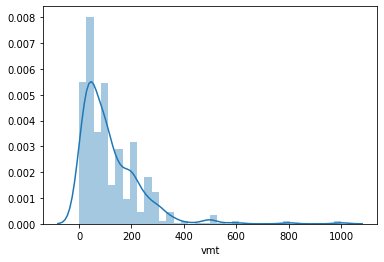

In [6]:
# check the distribution of the response variable
sns.distplot(df['vmt'])

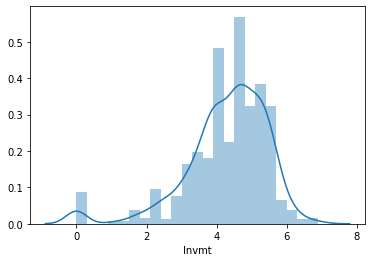

In [7]:
# vmt column is right-skewed with some 0 values.  Take the natural log of vmt+1 to transform
df["lnvmt"] = np.log(df['vmt']+1)
sns.distplot(df["lnvmt"])

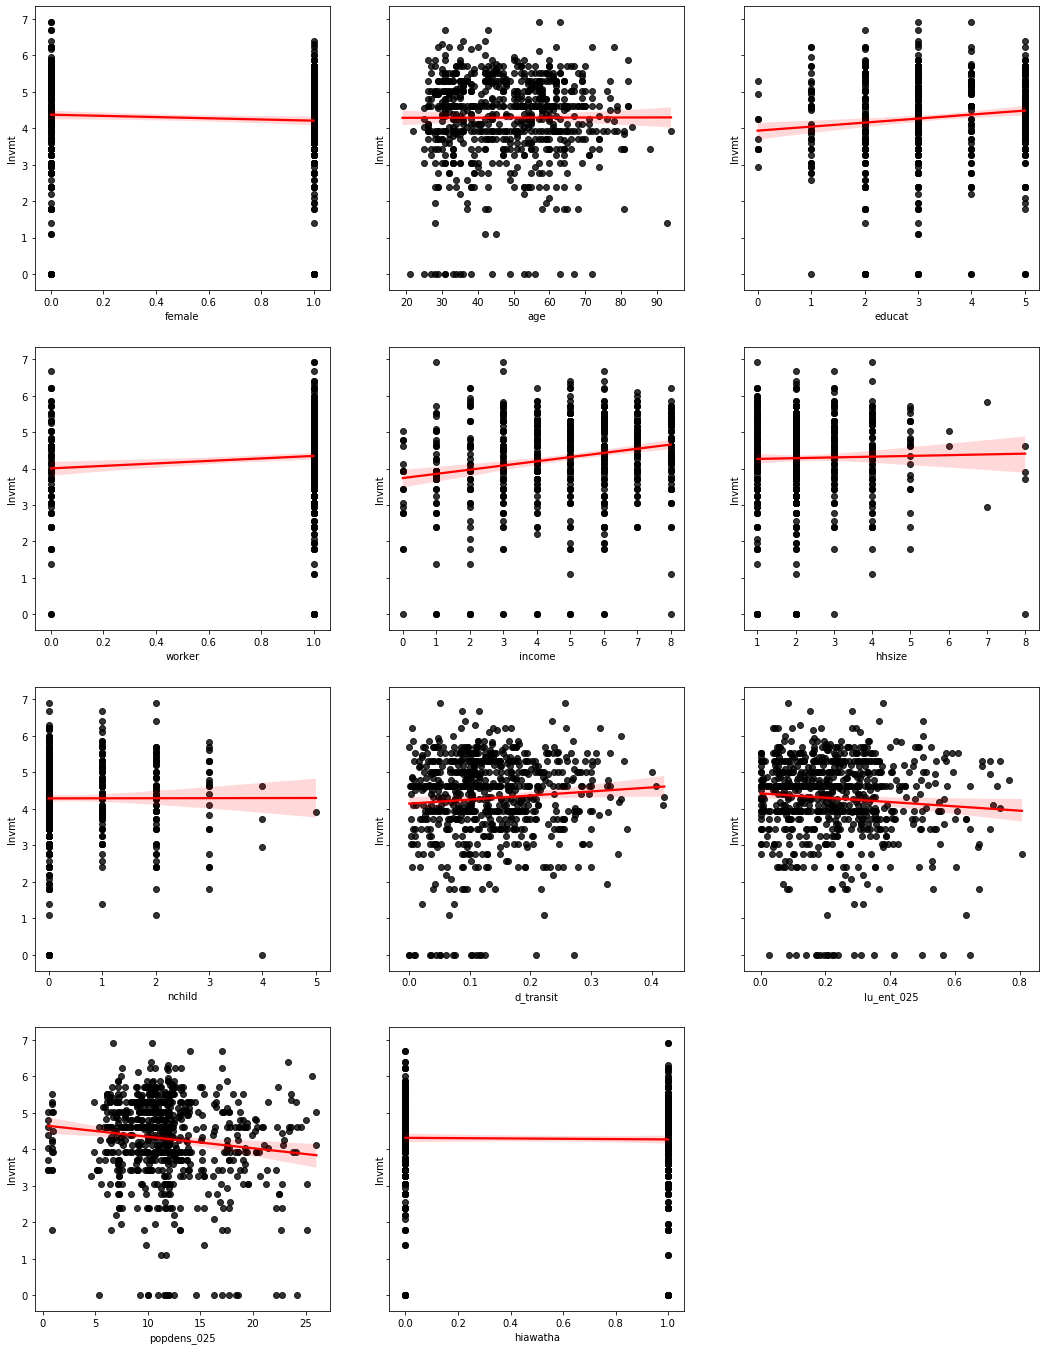

In [8]:
# now that we have encoded explanatory variables and a normal-enough response variable
# we can explore the relationships between the variables graphically.
# create a scatterplot with regression line for the response variable against every explanatory variable

# get a list of the explanatory variables in the dataframe
vars = df.columns[2:13]

#lay out the figure
cols = 3
rows = math.ceil(len(vars)/3)
fig, axes = plt.subplots(rows, cols, sharey='row', figsize=(6*cols, 6*rows))

# populate the figure with plots for each relationship
for i in range(rows * cols):
    pltax = axes[i // cols, i % cols] # the axis in which the plot will be
    if i+1 <= len(vars):
        sns.regplot(x=vars[i], 
                    y='lnvmt', 
                    data=df, 
                    scatter_kws={'color': 'black'}, 
                    line_kws={'color': 'red'}, 
                    ax=pltax)
    else:
        fig.delaxes(pltax) # delete extra axes that aren't needed for a plot

In [9]:
# create an OLS regression model using every explanatory variable as a baseline
X = df[vars]
y = df['lnvmt']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnvmt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     5.054
Date:                Sun, 16 Feb 2020   Prob (F-statistic):           1.20e-07
Time:                        12:00:33   Log-Likelihood:                -1202.5
No. Observations:                 772   AIC:                             2429.
Df Residuals:                     760   BIC:                             2485.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.8375      0.374     10.268      0.000       3.104       4.571
female         -0.1433      0.085     -1.680      0.093      -0.311       0.024
age             0.0045      0.003      1.339      0.181      -0.002       0.011
educat          0.0520      0.036      1.451      0.147      -0.018       0.122
worker          0.2560      0.127      2.019      0.044       0.007       0.505
income          0.0848      0.024      3.587      0.000       0.038       0.131
hhsize         -0.0461      0.066     -0.696      0.486      -0.176       0.084
nchild          0.0473      0.092      0.513      0.608      -0.134       0.228
d_transit       0.5105      0.550      0.928      0.354      -0.570       1.591
lu_ent_025     -0.1976      0.278     -0.711      0.477      -0.743       0.348
popdens_025    -0.0280      0.011     -2.600      0.009      -0.049      -0.007
hiawatha       -0.1701      0.095     -1.795      0.073      -0.356       0.016
==============================================================================
Omnibus:                      177.698   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.775
Skew:                          -1.229   Prob(JB):                     2.84e-89
Kurtosis:                       5.577   Cond. No.                         706.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

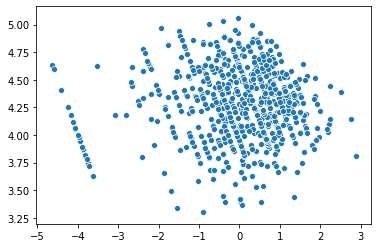

In [10]:
# graph the residuals vs the predicted values, should be more or less random
sns.scatterplot(x=model.resid, y=model.fittedvalues)

In [12]:
# test the residuals for heteroskedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

[('F statistic', 0.9343784981301361), ('p-value', 0.744025453667118)]

In [13]:
# Since we would like to draw conclusions about a population from the sample,
# we are more interested in the model's ability to explain future data
# than in its ability to explain the distribution of the sample.
# That means we want a model that minimizes AIC, not one that maximizes R2

X2 = df[['income', 'popdens_025', 'hiawatha']]

X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnvmt   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     14.47
Date:                Sun, 16 Feb 2020   Prob (F-statistic):           3.57e-09
Time:                        12:00:54   Log-Likelihood:                -1208.5
No. Observations:                 772   AIC:                             2425.
Df Residuals:                     768   BIC:                             2444.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2588      0.197     21.622      0.000       3.872       4.645
income          0.1037      0.020      5.153      0.000       0.064       0.143
popdens_025    -0.0317      0.010     -3.038      0.002      -0.052      -0.011
hiawatha       -0.1804      0.093     -1.930      0.054      -0.364       0.003
==============================================================================
Omnibus:                      172.150   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.543
Skew:                          -1.198   Prob(JB):                     4.26e-85
Kurtosis:                       5.517   Cond. No.                         65.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

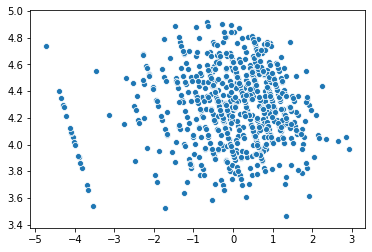

In [14]:
# graph the residuals vs the predicted values, should be more or less random
sns.scatterplot(x=model2.resid, y=model2.fittedvalues)

In [15]:
# test the residuals for heteroskedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model2.resid, model2.model.exog)
lzip(name, test)

[('F statistic', 0.9216373068235644), ('p-value', 0.7872253438032233)]

In [ ]:
# test the residuals for spatial autocorrelation